In [1]:
import os
import numpy as np
import glob
import PIL.Image as Image

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision import models
from torchsummary import summary
import torch.optim as optim
from time import time

import matplotlib.pyplot as plt
from IPython.display import clear_output
import xml.etree.ElementTree as ET
import matplotlib.patches as patches
import cv2

import os
import sys
sys.path.append('/zhome/65/e/156416/E24/IDLCV/Detection_deeplearning_in_computervision')
sys.path.append('/zhome/b6/d/154958/Potholes_boxing/Detection_deeplearning_in_computervision')
data_path = '/zhome/b6/d/154958/Potholes_boxing/Detection_deeplearning_in_computervision/Potholes/Potholes/annotated-images'

from Simple_cnn import train, Simple_CNN
from frednet import PotholeDataset, plot_image_with_bboxes

In [6]:
class Simple_CNN(nn.Module):
    def __init__(self, dropOutVal=0.2, num_classes=2):
        super(Simple_CNN, self).__init__()

        # Convolutional Feature Extraction
        self.network = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # 128x128x3 -> 64x64x64

            nn.Dropout2d(dropOutVal),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # 64x64x128 -> 32x32x128

            nn.Dropout2d(dropOutVal),
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            
            nn.Dropout2d(dropOutVal),
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            
            nn.Dropout2d(dropOutVal),
            nn.Conv2d(512, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # 32x32x128 -> 16x16x128

            nn.Dropout2d(dropOutVal),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            
            nn.Dropout2d(dropOutVal),
            nn.Conv2d(256, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # 16x16x64 -> 8x8x64
        )
        
        # Calculate flattened size of the feature map after the last conv layer
        test_input = torch.rand(1, 3, 128, 128)  # Sample input image
        flattened_size = self.network(test_input).view(1, -1).size(1)
        # Fully Connected Layer for shared features
        self.shared_fc = nn.Linear(flattened_size , 256)
        
        # Classification Head
        self.classifier = nn.Sequential(
            nn.ReLU(),
            nn.Linear(256, num_classes)  # Output layer for classification
        )
        
        # Regression Head
        self.regressor = nn.Sequential(
            nn.ReLU(),
            nn.Linear(256, 4)  # Output layer for bounding box adjustments (x, y, w, h)
        )

    def forward(self, x):
        # Pass through the convolutional feature extractor 
        features = self.network(x).view(x.size(0), -1)  # Flatten
        shared_features = self.shared_fc(features)  # Shared FC layer
        
        # Classification and Regression outputs
        class_out = self.classifier(shared_features)
        # bbox_out = self.regressor(shared_features)
        
        return class_out


    
dataset_ = PotholeDataset(data_path)


In [60]:
import torch
import torch.nn as nn
import timm  # Library with EfficientNet and other architectures

class EfficientNetModel(nn.Module):
    def __init__(self, num_classes=2, dropOutVal=0.2):
        super(EfficientNetModel, self).__init__()
        
        # Load EfficientNet backbone from timm, e.g., 'efficientnet_b0'
        self.backbone = timm.create_model('efficientnet_b2', pretrained=True, num_classes=0)  # Remove final layer
        self.backbone.eval()  # Freeze EfficientNet layers if desired
        
        # Add shared fully connected layers after feature extraction
        self.shared_fc = nn.Linear(1408, 256)  # 1280 output channels from EfficientNet-B0

        # Classification Head
        self.classifier = nn.Sequential(
            nn.ReLU(),
            nn.Dropout(dropOutVal),
            nn.Linear(256, num_classes)
        )
        
        # Regression Head
        self.regressor = nn.Sequential(
            nn.ReLU(),
            nn.Dropout(dropOutVal),
            nn.Linear(256, 4)  # Output for bounding box adjustments (x, y, w, h)
        )

    def forward(self, x):
        # Extract features using EfficientNet
        features = self.backbone(x)
        shared_features = self.shared_fc(features)
        
        # Output classification and bounding box predictions
        class_out = self.classifier(shared_features)
        
        return class_out
    
dataset_ = PotholeDataset(data_path)


In [61]:

def extract_edge_boxes(image, model_path='/zhome/b6/d/154958/Potholes_boxing/Detection_deeplearning_in_computervision/model.yml.gz', max_boxes=100, alpha=0.75, beta=0.75):
    # Load the pre-trained edge detection model
    edge_detection = cv2.ximgproc.createStructuredEdgeDetection(model_path)
    
    # Detect edges and compute orientation map
    edges = edge_detection.detectEdges(np.float32(image) / 255.0)
    orientation_map = edge_detection.computeOrientation(edges)
    
    # Create Edge Boxes object
    edge_boxes = cv2.ximgproc.createEdgeBoxes()
    edge_boxes.setMaxBoxes(max_boxes)
    edge_boxes.setAlpha(alpha) # Step size of the sliding window. Typical values range from 0.5 to 0.75.
    edge_boxes.setBeta(beta) #  Non-maximum suppression threshold. Typical values range from 0.6 to 0.9.
    
    # Get bounding boxes
    boxes, scores = edge_boxes.getBoundingBoxes(edges, orientation_map)
    return boxes, scores

In [49]:
import concurrent.futures
import random

def process_single_image(idx, dataset, iou_threshold, max_background_proposals):
    image, annotation = dataset[idx]
    boxes, scores = extract_edge_boxes(image)
    
    image_proposals = []
    image_labels = []
    background_proposals = []
    
    for box in boxes:
        x, y, w, h = box
        proposal_area = w * h
        label = 0

        for obj in annotation['objects']:
            if 'bndbox' in obj:
                gt_x = obj['bndbox']['xmin']
                gt_y = obj['bndbox']['ymin']
                gt_w = obj['bndbox']['xmax'] - gt_x
                gt_h = obj['bndbox']['ymax'] - gt_y

                inter_x1 = max(x, gt_x)
                inter_y1 = max(y, gt_y)
                inter_x2 = min(x + w, gt_x + gt_w)
                inter_y2 = min(y + h, gt_y + gt_h)

                inter_area = max(0, inter_x2 - inter_x1) * max(0, inter_y2 - inter_y1)
                union_area = proposal_area + gt_w * gt_h - inter_area

                iou = inter_area / union_area

                if iou >= iou_threshold:
                    label = 1
                    break

        if label == 1:
            image_proposals.append([x, y, w, h])
            image_labels.append(label)
        else:
            background_proposals.append([x, y, w, h])

    sampled_backgrounds = random.sample(background_proposals, min(len(background_proposals), max_background_proposals))

    for bg_proposal in sampled_backgrounds:
        image_proposals.append(bg_proposal)
        image_labels.append(0)

    return {
        "image": image,
        "proposals": torch.tensor(image_proposals),
        "labels": torch.tensor(image_labels)
    }

def prepare_proposals_for_training_parallel(dataset, iou_threshold, max_images=None, max_background_proposals=20):
    total_images = min(max_images, len(dataset)) if max_images is not None else len(dataset)
    with concurrent.futures.ThreadPoolExecutor() as executor:
        results = list(executor.map(
            lambda idx: process_single_image(idx, dataset, iou_threshold, max_background_proposals), range(total_images)
        ))
    return results

data = prepare_proposals_for_training_parallel(dataset_, iou_threshold=0.7, max_images=665, max_background_proposals=5)

In [62]:
import torch
from torch.utils.data import Dataset
from torch.utils.data import random_split

from PIL import Image

class ObjectDetectionDataset(Dataset):
    def __init__(self, data, image_size=(500, 500)):
        self.data = data
        self.image_size = image_size
        self.transform = transforms.Compose([
            transforms.Resize(image_size),
            transforms.ToTensor()
        ]
                                            )

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data[idx]
        image = item['image']
        proposals = item['proposals']  # Original proposals
        labels = item['labels']        # Labels for each proposal

        # Convert NumPy array to PIL image
        if isinstance(image, np.ndarray):
            image = Image.fromarray(image)

        # Get original dimensions for scaling proposals
        original_width, original_height = image.size
        image = self.transform(image)  # Apply transformations

        # Calculate scaling factors
        scale_x = self.image_size[0] / original_width
        scale_y = self.image_size[1] / original_height

        # Scale each proposal box
        scaled_proposals = [[
            box[0] * scale_x,
            box[1] * scale_y,
            box[2] * scale_x,
            box[3] * scale_y
        ] for box in proposals]

        return {
            'image': image,
            'proposals': torch.tensor(scaled_proposals, dtype=torch.float),
            'labels': torch.tensor([1 if label == 1 else 0 for label in labels], dtype=torch.long)
        }

# Step 1: Define dataset
dataset = ObjectDetectionDataset(data)

# Step 2: Split dataset
total_size = len(dataset)
train_size = int(0.7 * total_size)
val_size = int(0.15 * total_size)
test_size = total_size - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# Step 3: Create DataLoaders
train_dataloader = DataLoader(train_dataset, batch_size=1, shuffle=True, num_workers=4)
val_dataloader = DataLoader(val_dataset, batch_size=1, shuffle=False, num_workers=4)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=4)

In [63]:
def calculate_background_freq(dataloader):
    length_of_labels = 0 
    sum_of_labels = 0
    for batch in dataloader:
        
        length_of_labels += batch["labels"].flatten().size()[0]
        sum_of_labels += batch["labels"].sum()
    return sum_of_labels/length_of_labels

calculate_background_freq(train_dataloader)

tensor(0.2153)

In [ ]:
import torch
import torch.optim as optim
import torch.nn as nn

# Initialize model, optimizer, and loss functions
# model = Simple_CNN(num_classes = 2,dropOutVal=0.2)
model = EfficientNetModel(dropOutVal=0.2, num_classes=2)  # Adjust num_classes as needed
optimizer = optim.Adam(model.parameters(), lr=0.001)
classification_criterion = nn.CrossEntropyLoss()
regression_criterion = nn.SmoothL1Loss()

# Training pass function
def train_one_epoch(model, dataloader, optimizer, classification_criterion, regression_criterion, device):
    model.train()
    total_classification_loss = 0

    for batch in dataloader:
        # Unpack the batch
        image = batch['image'].to(device)             # Single image tensor
        proposals = batch['proposals'].squeeze(0).to(device)     # List of proposal boxes
        labels = batch['labels'].to(device)           # List of labels for each proposal

        # Forward pass for each proposal box
        batch_classification_loss = 0
        for i, proposal in enumerate(proposals):
            
            # Extract each proposal region from the image
            x, y, w, h = proposal.int()
            proposal_region = image[:, :, y:y+h, x:x+w]  # Crop the proposal region

            # Resize the cropped proposal region to the model's expected input size, e.g., (3, 64, 64)
            proposal_resized = nn.functional.interpolate(proposal_region, size=(288 , 288 ), mode='bilinear')

            # Forward pass through the model
            class_out = model(proposal_resized)

            # Compute the classification loss for this proposal
            
            target_class = labels.squeeze(0)[i].unsqueeze(0)  # Make it batch size 1 for compatibility

            classification_loss = classification_criterion(class_out, target_class)
            batch_classification_loss += classification_loss

            # Compute the regression loss for this proposal


        # Average the losses for all proposals in this image
        batch_classification_loss /= len(proposals)

        # Backpropagation
        total_loss = batch_classification_loss
        total_loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        # Accumulate loss for monitoring
        total_classification_loss += batch_classification_loss.item()

    # Compute average losses
    avg_classification_loss = total_classification_loss / len(dataloader)

    print(f"Avg Classification Loss: {avg_classification_loss:.4f}")


# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
# Training loop
num_epochs = 10  # Adjust the number of epochs as needed
for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")
    train_one_epoch(model, train_dataloader, optimizer, classification_criterion, regression_criterion, device)

Epoch 1/10


In [ ]:
import torch

# Helper function to calculate IoU
def calculate_iou(pred_box, gt_box):
    # Unpack coordinates
    x1_pred, y1_pred, w_pred, h_pred = pred_box
    x1_gt, y1_gt, w_gt, h_gt = gt_box

    # Calculate corners for prediction and ground truth
    x2_pred, y2_pred = x1_pred + w_pred, y1_pred + h_pred
    x2_gt, y2_gt = x1_gt + w_gt, y1_gt + h_gt

    # Calculate intersection
    x1_inter = max(x1_pred, x1_gt)
    y1_inter = max(y1_pred, y1_gt)
    x2_inter = min(x2_pred, x2_gt)
    y2_inter = min(y2_pred, y2_gt)

    inter_area = max(0, x2_inter - x1_inter) * max(0, y2_inter - y1_inter)
    
    # Calculate union
    pred_area = w_pred * h_pred
    gt_area = w_gt * h_gt
    union_area = pred_area + gt_area - inter_area

    iou = inter_area / union_area if union_area > 0 else 0
    return iou

def evaluate_iou_accuracy(model, test_dataloader, classification_criterion, regression_criterion, device, iou_threshold=0.7):
    model.eval()  # Set model to evaluation mode
    total_classification_loss = 0
    # total_regression_loss = 0
    correct_classifications = 0
    # correct_bboxes = 0
    total_proposals = 0

    with torch.no_grad():  # Disable gradient computation
        for batch in test_dataloader:
            image = batch['image'].to(device)
            proposals = batch['proposals'].squeeze(0).to(device)
            labels = batch['labels'].to(device)
            
            for i, proposal in enumerate(proposals):
                x, y, w, h = proposal.int()
                proposal_region = image[:, :, y:y + h, x:x + w]
                
                proposal_resized = nn.functional.interpolate(proposal_region, size=(128, 128), mode='bilinear')
                
                class_out = model(proposal_resized)
                
                # Get classification results
                _, predicted_class = torch.max(class_out, 1)
                true_class = labels.squeeze(0)[i]
                if predicted_class == true_class:
                    correct_classifications += 1

                # Calculate losses (optional for evaluation)
                classification_loss = classification_criterion(class_out, true_class.unsqueeze(0))
                # target_bbox = proposals[i].unsqueeze(0)
                # regression_loss = regression_criterion(bbox_out, target_bbox)
                
                total_classification_loss += classification_loss.item()
                # total_regression_loss += regression_loss.item()
                
                # Calculate IoU for bounding box
                # pred_bbox = bbox_out.squeeze(0).cpu()  # Predicted bounding box
                # gt_bbox = proposals[i].cpu()            # Ground truth bounding box
                # iou = calculate_iou(pred_bbox, gt_bbox)
                
                # Count correct bounding boxes if IoU > threshold
                # if iou > iou_threshold:
                #     correct_bboxes += 1

                total_proposals += 1

    # Calculate averages and accuracy
    avg_classification_loss = total_classification_loss / total_proposals
    # avg_regression_loss = total_regression_loss / total_proposals
    classification_accuracy = correct_classifications / total_proposals
    # bbox_accuracy = correct_bboxes / total_proposals
    
    print(f"Avg Classification Loss: {avg_classification_loss:.4f}")
    # print(f"Avg Regression Loss: {avg_regression_loss:.4f}")
    print(f"Classification Accuracy: {classification_accuracy:.4%}")
    # print(f"Bounding Box Accuracy (IoU > {iou_threshold}): {bbox_accuracy:.4%}")

# Run the IoU-based evaluation
evaluate_iou_accuracy(model, test_dataloader, classification_criterion, regression_criterion, device)


KeyboardInterrupt: 

In [230]:
model_file = open("EfficientNetb5_model.pkl","wb")
torch.save(model,model_file)

In [ ]:
import pickle
proposal_file = open("proposals.pkl", "wb")
labels_file = open("labels.pkl", "wb")

pickle.dump(proposals, proposal_file)
pickle.dump(labels, labels_file)
pickle.dump()

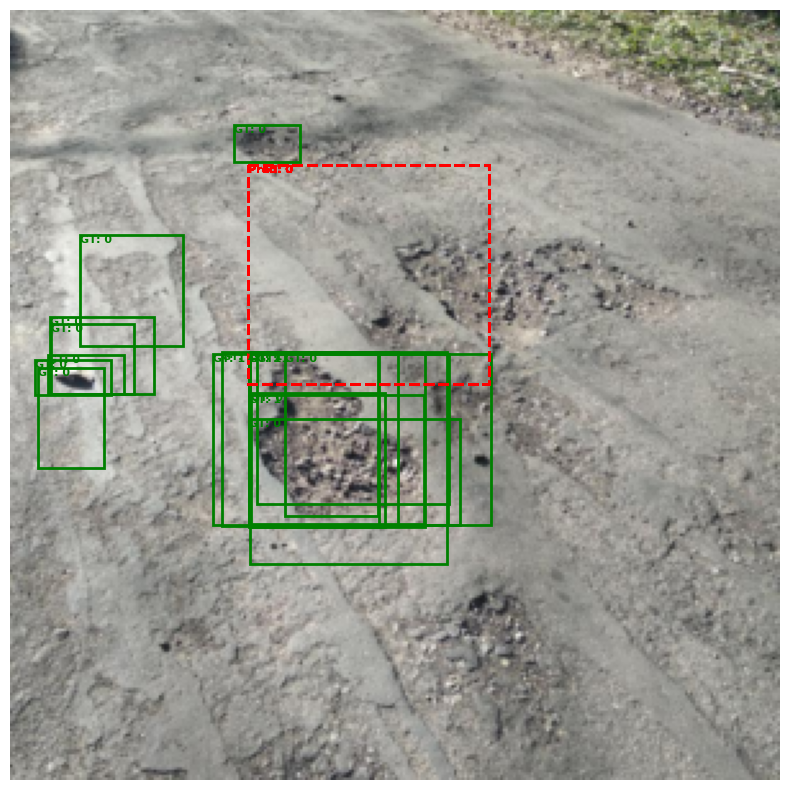

In [205]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import torch

def visualize_predictions(image, gt_boxes, pred_boxes, gt_labels, pred_labels, iou_threshold=0.7):
    """
    Visualizes ground truth and predicted bounding boxes on an image.
    
    Arguments:
    - image: The input image tensor.
    - gt_boxes: Ground truth bounding boxes (tensor of shape [N, 4]).
    - pred_boxes: Predicted bounding boxes (tensor of shape [M, 4]).
    - gt_labels: Labels for ground truth boxes.
    - pred_labels: Labels for predicted boxes.
    - iou_threshold: IoU threshold for correct prediction indication.
    """

    fig, ax = plt.subplots(1, figsize=(10, 10))
    # Convert the image tensor to a NumPy array and transpose dimensions for visualization
    image_np = image.cpu().numpy().transpose((1, 2, 0))
    ax.imshow(image_np)
    
    # Draw Ground Truth Boxes
    for i, box in enumerate(gt_boxes):
        x, y, w, h = box.cpu().numpy()
        rect = patches.Rectangle((x, y), w, h, linewidth=2, edgecolor='green', facecolor='none')
        ax.add_patch(rect)
        ax.text(x, y, f'GT: {gt_labels[i]}', color='green', verticalalignment='top', fontsize=8, weight='bold')
    
    # Draw Predicted Boxes
    for i, box in enumerate(pred_boxes):
        x, y, w, h = box.cpu().numpy()
        rect = patches.Rectangle((x, y), w, h, linewidth=2, edgecolor='red', facecolor='none', linestyle='--')
        ax.add_patch(rect)
        
        # Calculate IoU with each ground truth box
        is_correct = False
        for gt_box in gt_boxes:
            iou = calculate_iou(box, gt_box.cpu().numpy())
            if iou > iou_threshold:
                is_correct = True
                break
        
        label_color = 'blue' if is_correct else 'red'
        ax.text(x, y, f'Pred: {pred_labels[i]}', color=label_color, verticalalignment='top', fontsize=8, weight='bold')
    
    plt.axis('off')
    plt.show()

import torch.nn.functional as F

# Assume visualize_predictions is a function that takes an image, ground truth boxes, 
# predicted boxes, ground truth labels, and predicted labels for visualization.

for batch in test_dataloader:
    image = batch['image'][0]  # Get first image in batch
    gt_boxes = batch['proposals'][0]  # Ground truth boxes for this image
    gt_labels = batch['labels'][0]  # Ground truth labels for this image

    pred_boxes = []  # Store predicted boxes
    pred_classes = []  # Store predicted classes
    
    # Set the model to evaluation mode
    model.eval()
    with torch.no_grad():
        # Iterate over each ground truth bounding box
        for proposal in gt_boxes:
            x, y, w, h = proposal.int()
            proposal_region = image[:, y:y+h, x:x+w]  # Crop proposal region

            # Resize the proposal region to the model's expected input size
            proposal_resized = F.interpolate(proposal_region.unsqueeze(0), size=(128, 128), mode='bilinear')

            # Forward pass with the resized proposal
            class_out, bbox_out = model(proposal_resized.to(device))
            
            # Store the class and bbox predictions
            pred_classes.append(class_out.argmax(dim=1).cpu().item())
            pred_boxes.append(bbox_out.cpu().squeeze().tolist())  # Detach and convert to list

    # Convert lists to tensors for visualization compatibility
    pred_boxes = torch.tensor(pred_boxes)
    pred_classes = torch.tensor(pred_classes)

    # Visualize predictions vs ground truth
    visualize_predictions(image, gt_boxes, pred_boxes, gt_labels, pred_classes)
    
    break  # Visualize only the first batch for demo

